In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Data loading and preprocessing

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

normal_dataset = ImageFolder('/content/drive/MyDrive/Deep Learning/normal pictures', transform=transform)
art_dataset = ImageFolder('/content/drive/MyDrive/Deep Learning/art images', transform=transform)

normal_loader = DataLoader(normal_dataset, batch_size=1, shuffle=True)
art_loader = DataLoader(art_dataset, batch_size=1, shuffle=True)

In [5]:
# Checking normal images
normal_sizes = [img.size() for img, _ in normal_loader.dataset]
normal_unique_sizes = set(normal_sizes)
print("Unique image sizes in normal dataset:", normal_unique_sizes)

normal_channels = [img.size(0) for img, _ in normal_loader.dataset]
normal_unique_channels = set(normal_channels)
print("Unique color channels in normal dataset:", normal_unique_channels)

# Checking art images
art_sizes = [img.size() for img, _ in art_loader.dataset]
art_unique_sizes = set(art_sizes)
print("Unique image sizes in art dataset:", art_unique_sizes)

art_channels = [img.size(0) for img, _ in art_loader.dataset]
art_unique_channels = set(art_channels)
print("Unique color channels in art dataset:", art_unique_channels)

Unique image sizes in normal dataset: {torch.Size([3, 256, 256])}
Unique color channels in normal dataset: {3}
Unique image sizes in art dataset: {torch.Size([3, 256, 256])}
Unique color channels in art dataset: {3}


# StarGAN

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True)
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, c_dim, num_res_blocks):
        super(Generator, self).__init__()

        layers = [
            nn.Conv2d(3 + c_dim, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        ]

        # Down-sampling layers
        curr_dim = 64
        for _ in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim * 2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim * 2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim *= 2

        # Residual blocks
        for _ in range(num_res_blocks):
            layers.append(ResidualBlock(curr_dim))

        # Up-sampling layers
        for _ in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim // 2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim // 2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        c = c.view(c.size(0), c_dim, 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, image_size, c_dim, num_layers=5):
        super(Discriminator, self).__init__()

        layers = [
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.01)
        ]

        curr_dim = 64
        for i in range(1, num_layers):
            layers.append(nn.Conv2d(curr_dim, curr_dim * 2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim *= 2

        kernel_size = image_size // 2**num_layers
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)

    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))

# Hyperparameters
c_dim = 5
num_res_blocks = 9
image_size = 256

# Initialize generator and discriminator
G = Generator(c_dim=c_dim, num_res_blocks=num_res_blocks).to(device)
D = Discriminator(image_size=image_size, c_dim=c_dim).to(device)

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()


# Training

In [9]:
import os

# Directory for saving generated images
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Denormalization function
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Save Image Function
def save_image(tensor, filename):
    tensor = tensor.detach()
    tensor = tensor.add(1).div(2)
    tensor = tensor.clamp(0, 1)
    torchvision.utils.save_image(tensor, filename)

# Get labels for the images
def get_labels(image, dataset='normal'):
    if dataset == 'normal':
        return torch.zeros(image.size(0), dtype=torch.long)
    else:
        return torch.ones(image.size(0), dtype=torch.long)


num_epochs = 20
step = 0

# Losses to be used in the training
criterion_GAN = torch.nn.MSELoss().to(device)
criterion_cls = torch.nn.CrossEntropyLoss().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

def reset_grad():
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

# Training
d_losses = []
g_losses = []
for epoch in range(num_epochs):
    art_iter = iter(art_loader)
    for i, (normal_images, _) in enumerate(normal_loader):
        normal_images = normal_images.to(device)
        normal_labels = get_labels(normal_images, dataset='normal').to(device)

        try:
            art_images, _ = next(art_iter)
        except StopIteration:
            art_iter = iter(art_loader)
            art_images, _ = next(art_iter)

        art_images = art_images.to(device)
        art_labels = get_labels(art_images, dataset='art').to(device)

        # Real images and corresponding labels
        real_images = torch.cat([normal_images, art_images], dim=0)
        real_labels = torch.cat([normal_labels, art_labels], dim=0)

        # Compute loss with real images
        out_src, out_cls = D(real_images)
        d_loss_real = criterion_GAN(out_src, torch.ones_like(out_src)) + criterion_cls(out_cls, real_labels)

        # Generate fake images and labels
        fake_normal_labels = get_labels(normal_images, dataset='art').to(device)
        fake_art_labels = get_labels(art_images, dataset='normal').to(device)
        fake_normal_images = G(normal_images, F.one_hot(fake_normal_labels, num_classes=c_dim).float().to(device))
        fake_art_images = G(art_images, F.one_hot(fake_art_labels, num_classes=c_dim).float().to(device))

        # Compute loss with fake images
        fake_images = torch.cat([fake_normal_images, fake_art_images], dim=0)
        fake_labels = torch.cat([fake_normal_labels, fake_art_labels], dim=0)
        out_src, out_cls = D(fake_images.detach())
        d_loss_fake = criterion_GAN(out_src, torch.zeros_like(out_src)) + criterion_cls(out_cls, fake_labels)

        # Compute loss for the discriminator
        d_loss = d_loss_real + d_loss_fake

        # Optimize the discriminator
        reset_grad()
        d_loss.backward()
        optimizer_D.step()

         # Compute loss with fake images for the generator
        out_src, out_cls = D(fake_images)
        g_loss = criterion_GAN(out_src, torch.ones_like(out_src)) + criterion_cls(out_cls, fake_labels)

        # Compute loss for cycle consistency
        recon_normal = G(fake_art_images, F.one_hot(normal_labels, num_classes=c_dim).float().to(device))
        recon_art = G(fake_normal_images, F.one_hot(art_labels, num_classes=c_dim).float().to(device))

        g_loss_recon = criterion_cycle(recon_normal, normal_images) + criterion_cycle(recon_art, art_images)

        # Add it to the generator's loss
        g_loss += g_loss_recon

        # Optimize the generator
        reset_grad()
        g_loss.backward()
        optimizer_G.step()
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    fake_normal_images = fake_normal_images.detach().cpu()
    fake_art_images = fake_art_images.detach().cpu()
    save_image(fake_normal_images, f'samples/fake_normal_{epoch+1}.png')
    save_image(fake_art_images, f'samples/fake_art_{epoch+1}.png')


    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')


Epoch [1/20], d_loss: 1.4457578659057617, g_loss: 2.195093870162964
Epoch [2/20], d_loss: 0.48218536376953125, g_loss: 1.3686442375183105
Epoch [3/20], d_loss: 0.48842382431030273, g_loss: 1.5755728483200073
Epoch [4/20], d_loss: 0.4098147451877594, g_loss: 1.1625292301177979
Epoch [5/20], d_loss: 0.6065682768821716, g_loss: 1.2220125198364258
Epoch [6/20], d_loss: 0.6226940155029297, g_loss: 1.1847596168518066
Epoch [7/20], d_loss: 0.5421837568283081, g_loss: 1.4086717367172241
Epoch [8/20], d_loss: 0.41832607984542847, g_loss: 1.2949676513671875
Epoch [9/20], d_loss: 0.906792402267456, g_loss: 1.3380141258239746
Epoch [10/20], d_loss: 0.3939988315105438, g_loss: 1.3281700611114502
Epoch [11/20], d_loss: 0.8919236660003662, g_loss: 1.4894895553588867
Epoch [12/20], d_loss: 0.4688393175601959, g_loss: 1.1224557161331177
Epoch [13/20], d_loss: 0.23701545596122742, g_loss: 1.349637508392334
Epoch [14/20], d_loss: 0.2647015452384949, g_loss: 1.1102395057678223
Epoch [15/20], d_loss: 0.606

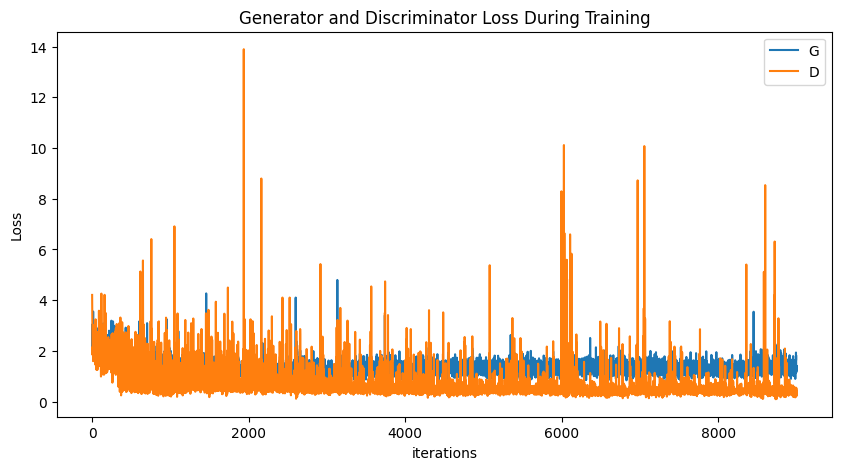

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")

plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import os
print(os.getcwd())

In [18]:
# Save the models
torch.save(G.state_dict(), '/content/G.pth')
torch.save(D.state_dict(), '/content/D.pth')
